# ta-lib-005 ( Feature‑Engineering + Sequence Models) Add train_test_split
https://chatgpt.com/c/680a20b3-65fc-800a-8d9e-3a3cc1fc90c9

In [ ]:
# Cell 1: Imports & Config
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import talib
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

# Ensure plots inline
%matplotlib inline

In [ ]:
# Cell 2: Parameters
DATA_PATH = "../datasets/XAGUSD-H1-rates.csv"   # Path to your downloaded MT5 CSV
SEQUENCE_LENGTH = 30                # Number of past candles per sample
PREDICT_HORIZON  = 5                # How many candles ahead to detect a trend change
TEST_SIZE = 0.2
RANDOM_STATE = 42
BATCH_SIZE = 64
EPOCHS = 50

In [ ]:
# Cell 3: Load & Inspect Data
df = pd.read_csv(DATA_PATH, sep='\t')
# Combine <DATE> and <TIME> into single datetime index
df['DATETIME'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'])
df.set_index('DATETIME', inplace=True)
df.drop(columns=['<DATE>', '<TIME>'], inplace=True)
df.head()

In [40]:
# Cell 4: Compute TA indicators
# e.g. RSI, ATR, MACD Histogram
df['rsi'] = talib.RSI(df['<CLOSE>'], timeperiod=14)
macd, macd_sig, macd_hist = talib.MACD(df['<CLOSE>'])
df['macd_hist'] = macd_hist
df['atr'] = talib.ATR(df['<HIGH>'], df['<LOW>'], df['<CLOSE>'], timeperiod=14)
df.dropna(inplace=True)

In [42]:
# Cell 5: Label trend‑change points
# Define trend: rolling slope on CLOSE, then detect flips
window = 5
df['slope'] = df['<CLOSE>'].diff(window)
df['trend'] = np.sign(df['slope'])
df['trend_change'] = df['trend'].diff().fillna(0).apply(lambda x: 1 if x>0 else (-1 if x<0 else 0))
#  1 = change to uptrend, -1 = change to downtrend, 0 = no change

In [44]:
# Cell 6: Feature Engineering & Sequence Creation
feature_cols = ['<CLOSE>','rsi','macd_hist','atr']
scaler = StandardScaler()
scaled = scaler.fit_transform(df[feature_cols])
labels = df['trend_change'].values

X, y = [], []
for i in range(len(df) - SEQUENCE_LENGTH - PREDICT_HORIZON + 1):
    seq_x = scaled[i : i+SEQUENCE_LENGTH]
    future_label = df['trend_change'].iloc[i+SEQUENCE_LENGTH : i+SEQUENCE_LENGTH+PREDICT_HORIZON].sum()
    # if any change in horizon: up/down/none
    label = 1 if future_label>0 else (-1 if future_label<0 else 0)
    X.append(seq_x)
    y.append(label)
X = np.array(X)
y = tf.keras.utils.to_categorical([l+1 for l in y], num_classes=3)  # map -1,0,1 to 0,1,2

In [45]:
# Cell 7: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (44012, 30, 4) (44012, 3)
Test : (11004, 30, 4) (11004, 3)


In [46]:
# Cell 8: Build the Sequence Model
def build_model(input_shape, num_classes=3):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(32),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

model = build_model((SEQUENCE_LENGTH, len(feature_cols)))
model.summary()


I0000 00:00:1745504010.892985    4233 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2316 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,235 (122.01 KB)

 Trainable params: 31,235 (122.01 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Cell 9: Training
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es]
)

Epoch 1/50


I0000 00:00:1745504019.124405    6512 cuda_dnn.cc:529] Loaded cuDNN version 90800


551/551 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.4709 - loss: 0.9875 - val_accuracy: 0.5037 - val_loss: 0.8317
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4864 - loss: 0.8483 - val_accuracy: 0.5026 - val_loss: 0.8152
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4997 - loss: 0.8284 - val_accuracy: 0.4867 - val_loss: 0.8138
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5005 - loss: 0.8224 - val_accuracy: 0.5068 - val_loss: 0.8007
Epoch 5/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5022 - loss: 0.8145 - val_accuracy: 0.5040 - val_loss: 0.8015
Epoch 6/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5054 - loss: 0.8131 - val_accuracy: 0.5090 - val_loss: 0.7974
Epoch 7/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5132 - loss: 0.7950 - val_accuracy: 0.4923 - val_loss: 0.7793
Epoch 8/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5062 - loss: 0.7853 - val_accuracy: 0.5147 - val_

In [48]:
# Cell 10: Evaluation
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}  Test Acc: {acc:.4f}")

344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5325 - loss: 0.7375
Test Loss: 0.7379  Test Acc: 0.5245


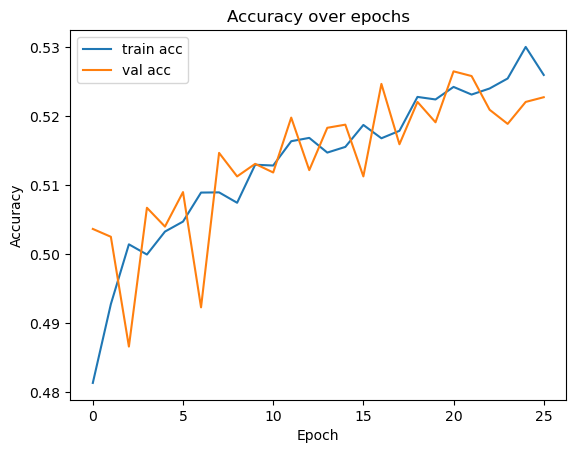

In [49]:
# Cell 11: Plot Training History
plt.figure()
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title("Accuracy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted: no‑change


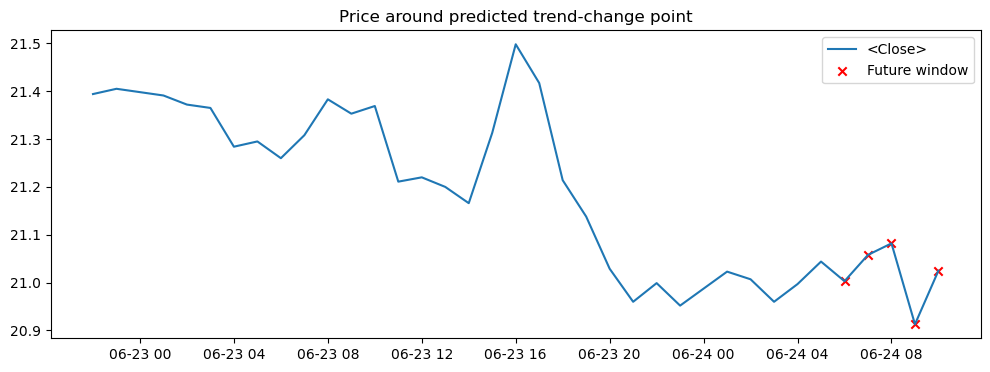

In [51]:
# Cell 12: Sample Predictions & Visualization
# Pick the last available sequence
seq = X_test[-1][None, ...]
pred = model.predict(seq)[0]
labels_map = {-1:'down‑change', 0:'no‑change', 1:'up‑change'}
print("Predicted:", labels_map[np.argmax(pred)-1])

# Plot the last SEQUENCE_LENGTH candles + indicator
idx = -1  # index in test set
orig_idx = len(df) - len(X_test) + idx + SEQUENCE_LENGTH
slice_df = df.iloc[orig_idx-SEQUENCE_LENGTH:orig_idx+PREDICT_HORIZON]
plt.figure(figsize=(12,4))
plt.plot(slice_df.index, slice_df['<CLOSE>'], label='<Close>')
plt.scatter(slice_df.index[SEQUENCE_LENGTH:],
            slice_df['<CLOSE>'].iloc[SEQUENCE_LENGTH:],
            c='red', marker='x', label='Future window')
plt.title("Price around predicted trend‑change point")
plt.legend(); plt.show()